# **AI in Medicine**
## **Session 2**: First Steps in Machine Learning

Welcome to the second programming workshop for the AI in Medicine series! 

Today we will be diving into some basic concepts in machine learning:
*    Unsupervised learning: Clustering
*    Unsupervised learning: Dimensionality Reduction with Principal Component Analysis (PCA)

*    Supervised learning: Classification with logistic regression and interpretation of model weights

Before you begin reading and editing any code, make sure to make a personal copy of this notebook by clicking `File` --> `Save a Copy in Drive` so you can make changes to the code.

## Imports and loading the dataset
Let's start the necessary `import`s for our code, and a simple dataset to demonstrate fundamental concepts in unsupervised learning. 

We will use the 'wine' dataset which is packaged in `sklearn` (scikit-learn), which contains 3 classes (of different wine variety) and 13 features.

In [45]:
# Load the necessary python libraries
from sklearn import cluster, decomposition, preprocessing, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine, load_breast_cancer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size': 14,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'figure.figsize' : [10,6],
                     })

In [46]:
# Load the wine dataset into a variable, and then print a description of the dataset
dataset = load_wine()
print(dataset['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

The dataset description tells us that there are 13 features based on chemical analysis of the wines, and 3 classes of wines (which are just denoted 'class_0', 'class_1', and 'class_2')

#**Unsupervised Learning**: Clustering Data

What if we only had measured 2 of the chemical analysis features and didn't know or couldn't label the different wine classes? Would we still be able to separate the data into classes?

Let's see what this looks like by scatter plotting the first two features on a 2D axis without class labels and with class labels. 

     alcohol  malic_acid   ash  ...  od280/od315_of_diluted_wines  proline  Label
0      14.23        1.71  2.43  ...                          3.92   1065.0      0
1      13.20        1.78  2.14  ...                          3.40   1050.0      0
2      13.16        2.36  2.67  ...                          3.17   1185.0      0
3      14.37        1.95  2.50  ...                          3.45   1480.0      0
4      13.24        2.59  2.87  ...                          2.93    735.0      0
..       ...         ...   ...  ...                           ...      ...    ...
173    13.71        5.65  2.45  ...                          1.74    740.0      2
174    13.40        3.91  2.48  ...                          1.56    750.0      2
175    13.27        4.28  2.26  ...                          1.56    835.0      2
176    13.17        2.59  2.37  ...                          1.62    840.0      2
177    14.13        4.10  2.74  ...                          1.60    560.0      2

[178 rows x 14 

Text(0.5, 1.0, 'With Ground Truth Labels')

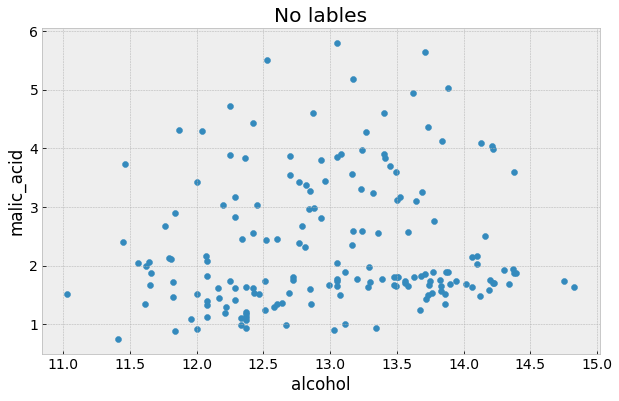

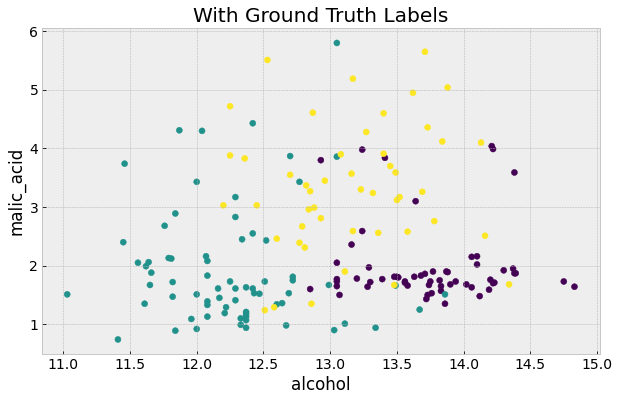

In [47]:
# First lets store the dataset as a dataframe using the pandas library
df = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
df['Label'] = dataset['target']
print(df)

feature_1 = 0
feature_2 = 1

# A scatter plot with no class labels
plt.figure()
plt.scatter(df.iloc[:,feature_1], df.iloc[:,feature_2]) # Here we are only plotting the first and second columns, which happen to be 'alcohol' and 'malic acid'
plt.xlabel(df.columns[feature_1])
plt.ylabel(df.columns[feature_2])
plt.title('No lables')

# A scatter plot with class labels
plt.figure()
plt.scatter(df.iloc[:,feature_1], df.iloc[:,feature_2], c=df['Label'])
plt.xlabel(df.columns[feature_1])
plt.ylabel(df.columns[feature_2])
plt.title('With Ground Truth Labels')

From the second figure, the three classes are discernible and somewhat grouped into three clusters. Is it possible to recover these clusters without having the class labels in the first place? Because we don't have class labels, this is an unsupervised learning problem

We will use K-means clustering to tackle this. This is the simplest clustering algorithm, which you can read about [here](https://en.wikipedia.org/wiki/K-means_clustering). With k-means clustering, we first have to make an assumption of how many classes there. As you can imagine, the algorithm is very sensitive to this assumption

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 2 2 2 0 2 0 2 2 0 0 0
 2 2 0 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 1 1 2 2 1 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 2 0 1 2 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 2 2 0 1 1 1 0 1]


Text(0.5, 1.0, 'K-Means Clustering Results with k=3')

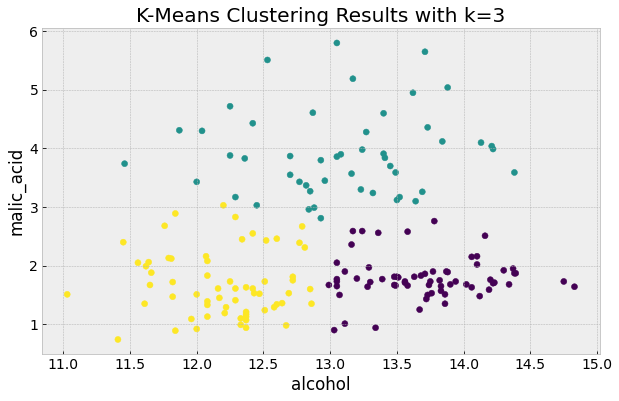

In [48]:
# We will first standardize the data to have zero mean and a variance of 1, which usually
# stabilizes and improves performance in most machine learning algorithms. This is a common preprocessing step
scaler = preprocessing.StandardScaler().fit(df.iloc[:,:-1]) # Define a scaler which standardizes the data to have mean 0 and standard devation 1. This usually improves stability and performance
df_scaled = scaler.transform(df.iloc[:,:-1]) #Use the scaler to transform the training and test data
df_scaled = pd.DataFrame(df_scaled)

k_means = cluster.KMeans(n_clusters=3, max_iter=5000) #We first define a k-means clustering object
k_means.fit(df_scaled.iloc[:,feature_1:feature_2+1]) #Then we fit it to our 2 feature dataset
print(k_means.labels_)

# Now we can visualize the clustering results and compare it to the truth from the figure above 
plt.figure()
plt.scatter(df.iloc[:,feature_1], df.iloc[:,feature_2], c=k_means.labels_)
plt.xlabel(df.columns[feature_1])
plt.ylabel(df.columns[feature_2])
plt.title('K-Means Clustering Results with k=3')

As you can see, K-means clustering does a good job of clustering the data into 3 classes which largely match the class clustering in the labeled data based on just the first two features.

There are clearly some downsides to K-means clustering: for it to be successful we have to some idea of how many clusters there are in the data. We also clustered just using the first two features, but we can also try using all 13 features (and then visualize the first two features again). Try this now:

Text(0.5, 1.0, 'K-Means Clustering on all features')

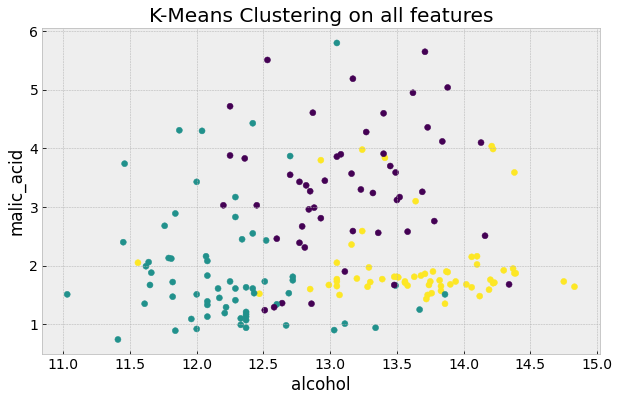

In [49]:
k_means.fit(df_scaled) #Fit K-means to all features (ignore the last label column)

# Now we can visualize the clustering results and compare it to the truth from the figure above 
plt.figure()
plt.scatter(df.iloc[:,feature_1], df.iloc[:,feature_2], c=k_means.labels_)
plt.xlabel(df.columns[feature_1])
plt.ylabel(df.columns[feature_2])
plt.title('K-Means Clustering on all features')

Using all 13 features means that the clustering algorithm can capture more complex characteristics that aren't evident from the first two features alone. Go back up and change `feature_1` and `feature_2` to some other numbers (between 0 and 12) to visualize the plots in other feature axes.

# **Unsupervised Learning**: Dimensionality Reduction with Principal Component Analysis (PCA)
When clustering above, we first chose to arbitrarily use and visualize the first two features. But these aren't necessarily the best features to work with, there could be some other combination of two (or more) features which better represent the data. 

If we cannot use all the features in our analysis, or we believe that all features we have collected in our data can be better represented by fewer features, how do we find the best features to use for analysis?

This is where we would use **dimensionality reduction**, which is another unsupervised learning technique. The purpose of dimensionality reduction is to find a combination of fewer features which best represent our data, without us needing to have any class/output labels associated with a particular outcome.

One of the most popular dimensionality reduction techniques is known as Principal Component Analysis (PCA), which finds linear combinations of features from the original dataset which best explains the majority of the variance. **NOTE:** Dimensionality reduction is different from feature selection, as dimensionality reduction results in new features which are combinations of original features in the dataset. Feature selection, on the other hand, preserves the original features. Both dimensionality reduction and feature selection are common steps in a pipeline before further machine learning analysis is used.

Let's now use PCA to find how many components are necessary to explain most of the variance in the wine dataset

The percent variance explained by the thirteen components is:  [36.1988481  19.20749026 11.12363054  7.06903018  6.56329368  4.93582332
  4.23867932  2.68074895  2.2221534   1.93001909  1.73683569  1.29823258
  0.79521489]


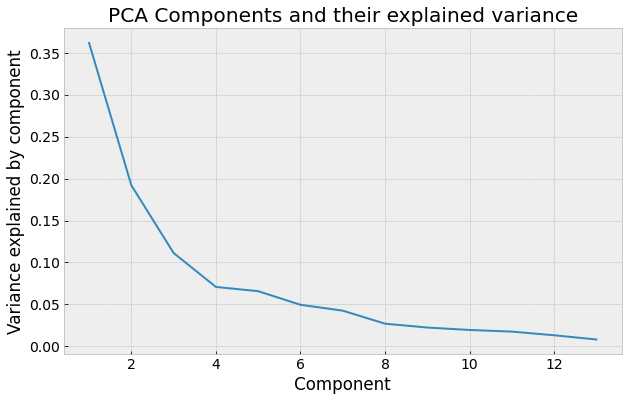

In [50]:
pca = decomposition.PCA() #Define a PCA object
pca.fit(df_scaled) # Solve PCA on the standardized wine dataset
df_pca = pca.transform(df_scaled) # Transform wine dataset into the principal components as found by the PCA algorithm

# Let's visualize how important each component is by looking at how much variance each component explains:
plt.figure()
plt.plot(range(1,14), pca.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Variance explained by component')
plt.title('PCA Components and their explained variance')
print("The percent variance explained by the thirteen components is: ", pca.explained_variance_ratio_ * 100)

We can see that most of the variance in the datasets is explained by the first 4 principal components. That means that we could use the 4 principal components to explain most of the data and therefore use those as features instead of the original 13.

We can see how useful this concept is by visualizing the first two principal components and seeing how straightforward it would be to cluster into the three classes compared to previously when we were using the first two features.

Text(0.5, 1.0, 'First two principal components of the wine dataset')

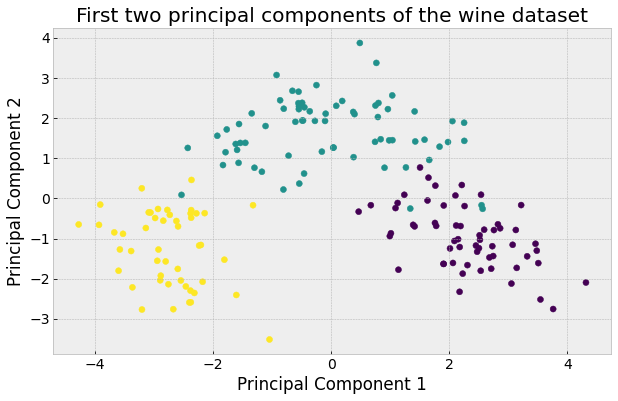

In [51]:
# Scatter plot the first two components and their true class labels
plt.figure()
plt.scatter(df_pca[:,0], df_pca[:,1], c=df['Label'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two principal components of the wine dataset')

What do the principal components actually mean? They are a linear combination of the original features. if we call `pca.components_` we can see the weight of the original features that make up each component. Below we can see the first component is most influenced by the 7th feature (magnitude of 0.423)

In [52]:
# Print the principal components. 
print(pca.components_[0,:])
print('The feature that most influences the first PC is ',df.columns[6])  # What is the 7th feature in the origina dataset?

[ 0.1443294  -0.24518758 -0.00205106 -0.23932041  0.14199204  0.39466085
  0.4229343  -0.2985331   0.31342949 -0.0886167   0.29671456  0.37616741
  0.28675223]
The feature that most influences the first PC is  flavanoids


# **Supervised Learning**: Classification with Logistic Regression

We will now switch gears and talk about supervised learning! Specifically, we will be looking at classification using logistic regression. 

We will be using the breast cancer dataset (from the first session) and use logistic regression to learn how to predict benign from malignant tumors.

Reminder: the breast cancer dataset has 539 tumor cases with 30 features each. Feel free to visualize and plot the features to explore the data

### We will start with logistic regression in one dimension (feature), before using all 30 features for classification

In [53]:
# Load breast cancer dataset and store as a Pandas dataframe
cancer = load_breast_cancer()
scaler = preprocessing.StandardScaler().fit(cancer.data) # Define a scaler which standardizes the data to have mean 0 and standard devation 1. This usually improves stability and performance
cancer_data_scaled = scaler.transform(cancer.data) #Use the scaler to transform the training and test data

df = pd.DataFrame(data=cancer_data_scaled, columns=cancer['feature_names'])
df['Label'] = cancer['target']

## Training a logistic regression classifier

Recall that a logistic regression classifier will find a linear decision boundary given your data feaures. In this case, the logistic regression algorithm will find a linear boundary in the 30 features in the cancer dataset.

Here's a reminder of what a logistic function looks like with a single feature (x-axis) for a single output (y-axis).


<img src="https://static.javatpoint.com/tutorial/machine-learning/images/logistic-regression-in-machine-learning.png">

Logistic regression fits a sigmoid function (the red curve), which takes the mathematical form:

$$ y(x)=\frac{1}{1+e^{-(\mathbf{w}x + \mathbf{b})}} $$

Where $\mathbf{w}$ and $\mathbf{b}$ are the learned weights and bias of the model, also known as the coefficients for each feature in the model. We can use the learned $\mathbf{w}$ and $\mathbf{b}$ to claculate the odds of the output happening when the input feature changes.

Training Error on first feature:  0.8849765258215962
Test Error on first feature:  0.8601398601398601
The model coefficients are:  [[-3.45590729]] [0.64703868]


Text(0, 0.5, 'Class')

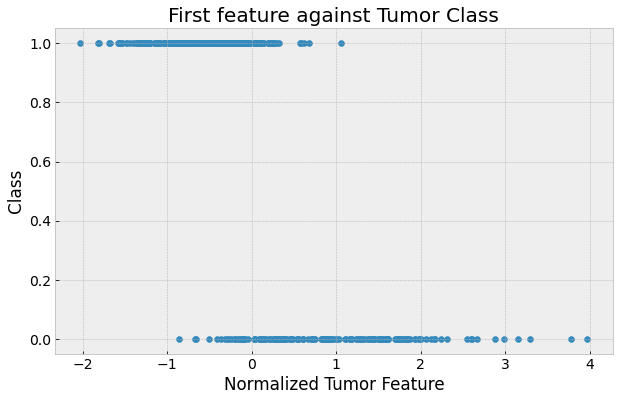

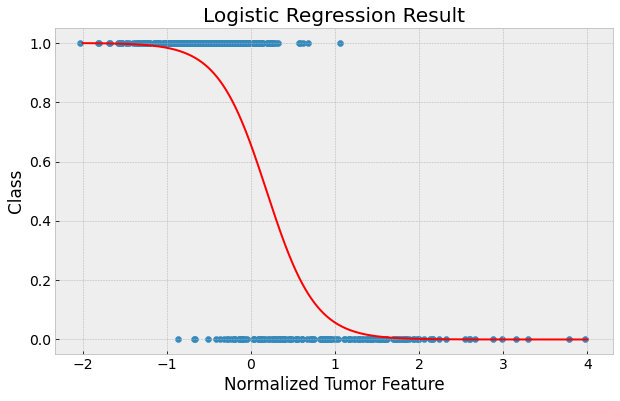

In [54]:
# Split the dataset into training and test sets using sklearn's train_test_split, the train/test split is 25/75% by default
X_train, X_test, y_train, y_test = model_selection.train_test_split(cancer_data_scaled, cancer.target, random_state=1)

# Select only the first feature in the dataset
X_train_one_feature = X_train[:,0].reshape(-1,1)
X_test_one_feature = X_test[:,0].reshape(-1,1)

# Visualize the first feature with respect to the label
plt.figure()
plt.scatter(X_train_one_feature, y_train)
plt.xlabel('Normalized Tumor Feature')
plt.ylabel('Class')
plt.title('First feature against Tumor Class')

# Train a logistic regression classifier on the first feature, and then visualize the classification threshold
logReg = LogisticRegression(max_iter=5000, random_state=1) # Define a logistic regression classifier with 5000 iterations, and a fixed random state of 1
logReg.fit(X_train_one_feature, y_train) #Train it on just the first feature (first column) and the labels

print('Training Error on first feature: ',logReg.score(X_train_one_feature, y_train)) # Print the training and test errors
print('Test Error on first feature: ', logReg.score(X_test_one_feature, y_test))
print('The model coefficients are: ', logReg.coef_, logReg.intercept_)

# Visualize the logistic regression results
plt.figure()
plt.scatter(X_train_one_feature, y_train)
sigmoid_x = np.linspace(-2,4,500).reshape(-1,1)
sigmoid_y = 1/(1+np.exp(-(sigmoid_x*logReg.coef_ + logReg.intercept_)))
plt.plot(sigmoid_x, sigmoid_y, color='red', linewidth=2)
plt.title('Logistic Regression Result')
plt.xlabel('Normalized Tumor Feature')
plt.ylabel('Class')

Clearly, the first feature isn't great on its own to predict malignant versus benign tumors. The training and test accuracies are approximately 88% and 86% respectively. You can see in the above plot that the tumor samples are not linearly separable.



---





## Logistic regression coefficients for calculating odds and odds ratios

We can use the learned coefficients (which above were $\mathbf{w} = -3.46$ and $\mathbf{b} = 0.65$) to calculate the log-odds.

For example, if the normalized tumor feature has a value of 0, then the 

log-odds $= -3.46*0 + 0.65 = 0.65$

odds $= exp(0.65) = 1.92$

**Which means the odds of a tumor being benign (class 1) are 1.92, when the first feature has a value equal to 0**

We can also calculate odds ratio in a similar way. When the feature value changes to 1:

log-odds $= -3.46*1 + 0.65 = -2.81$

odds $= exp(-2.81) = 0.06$

odds-ratio $= 0.06/1.92 = 0.03$

**Therefore the odds that a tumor, when the first feature equals 1, being benign is 0.03 times less than the odds of a tumor when the first feature equals 0** 


---



We can also train the logistic regression to classify tumors using all 30 features. We expect this to be more successful than the one feature case.

In [55]:
# Train a logistic regression classifier oveer all features
logReg.fit(X_train, y_train) # Fit the logistic regression model to the full training set
 
print('Training Error: ',logReg.score(X_train, y_train)) # Print the training and test errors
print('Test Error: ', logReg.score(X_test, y_test))
print('The model coefficients are: ', logReg.coef_, logReg.intercept_)

Training Error:  0.9906103286384976
Test Error:  0.9790209790209791
The model coefficients are:  [[-0.45856114 -0.39546554 -0.44517615 -0.49703821 -0.0858236   0.30482898
  -0.72127131 -0.76435998 -0.02816754  0.35960701 -1.06679318 -0.03329303
  -0.53688629 -0.76075692 -0.21751766  0.9024823  -0.0726892  -0.4931397
   0.1774552   0.71235893 -1.05094738 -0.96507714 -0.90281058 -0.97922538
  -0.42311568 -0.04773773 -0.83153207 -0.93341487 -0.79438484 -0.64624262]] [0.33289946]


Because the test accuracy is very high (~98%), we can conclude that it is possible to linearly separate benign and malignant tumors using all 30 features provided in the dataset.

You might be interested in experimenting with PCA to reduce the dimensionality of the tumor dataset to only two features, and test if it is possible to do accurate classification with logistic regression.